# Load pytorch library

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


# Define validation dataset ratio

In [2]:

valid_ratio = 0.3

# Define the MNIST training and validation sets, and possible transforms to be applied. Optional augmentation can be done within the transform. 

In [3]:
transform = transforms.Compose(
    [
     # define your data augmentation here!
    #  transforms.RandomRotation(degrees=30),
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

train_valid_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=500,
                                          shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=500,
                                          shuffle=True)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

# Visualize the MNIST dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


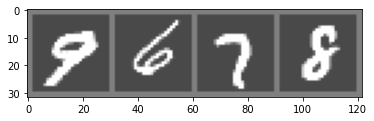

9     6     7     8


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4,]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Construct the CNN.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define your CNN here, e.g. activation function: F.sigmoid or F.relu

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = F.sigmoid(self.conv3(x))
        x = x.view(-1, 32 * 7 * 7)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x



# Instantiate the CNN and print out the number of parameters.

In [6]:
net = Net()
print(sum([p.numel() for p in net.parameters()]))
PATH = 'C:/Users/Ryan/Desktop/Part 2/cnn'

884330


# Define the loss function and the optimizer.

In [10]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
# define your optimizer and its learning rate (lr) here!
optimizer = optim.Adam(net.parameters(), lr=0.01)
print(optimizer.defaults['lr'])

0.01


# Select the device to train the CNN! "cuda:0" means the first GPU device.

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

# Train the CNN and store the best model based on the validation loss.

In [27]:
import time
import os as OO

start_time = time.time()
best_loss = np.float('inf')
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss / (i+1)
    print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)
    with torch.no_grad(): 
      running_loss = 0.0
      for i, data in enumerate(validloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # forward 
          outputs = net(inputs)
          loss = criterion(outputs, labels)

          # print statistics
          running_loss += loss.item()
      epoch_loss = running_loss / (i+1)
      print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)
      # save the best model based on validation loss
      if epoch_loss < best_loss:
        torch.save(net.state_dict(), OO.path.join(PATH, 'cnn.pth'))
        best_loss = epoch_loss

time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)

Epoch:  0  train loss:  2.313
Epoch:  0  validation loss:  2.304
Epoch:  1  train loss:  2.303
Epoch:  1  validation loss:  2.304
Epoch:  2  train loss:  2.303
Epoch:  2  validation loss:  2.306
Epoch:  3  train loss:  2.304
Epoch:  3  validation loss:  2.305
Epoch:  4  train loss:  2.304
Epoch:  4  validation loss:  2.302
Epoch:  5  train loss:  2.303
Epoch:  5  validation loss:  2.306
Epoch:  6  train loss:  2.304
Epoch:  6  validation loss:  2.303
Epoch:  7  train loss:  2.304
Epoch:  7  validation loss:  2.303
Epoch:  8  train loss:  2.303
Epoch:  8  validation loss:  2.303
Epoch:  9  train loss:  2.302
Epoch:  9  validation loss:  2.302
Finished Training in 1 mins


# Define the test dataset.

In [28]:
transform = transforms.Compose(
     [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)

# Visualize the test dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


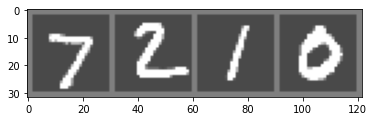

GroundTruth:      7     2     1     0


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Load the learned CNN parameters. This is required when you have trained the CNN and do no want to train it again by loading the learned parameters.

In [30]:
net.load_state_dict(torch.load(OO.path.join(PATH, 'cnn.pth')))

<All keys matched successfully>

# Get the predictions for the first 4 images in the test dataset.

In [31]:
with torch.no_grad():
  outputs = net(images.to(device))
  _, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      1     1     1     1


# Infer on the whole test dataset.

In [32]:
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=1)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %.3F %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 11.350 %


# check the GPU device assigned by Google.

In [34]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Wed Dec 16 17:01:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:0B:00.0  On |                  N/A |
| 26%   55C    P0    35W / 151W |   3030MiB /  8192MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

'ln' is not recognized as an internal or external command,
operable program or batch file.
